# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [4]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

from imageio import imread
from skimage.transform import resize

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras.applications import mobilenet

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(30)

2.7.0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [6]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [7]:
## Checking the GPU configuration
!nvidia-smi

Tue Aug 27 03:12:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:1E:00.0 Off |                  Off |
| 34%   30C    P8              13W / 230W |      6MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Function to plot loss and accuracy

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Function to calculate steps

In [9]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

#### Function for callbacks

In [10]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

### Visualizing few images before and after Standardisation

#### Before Standardisation

image shapes before cropping and resizing (360, 360, 3) (120, 160, 3)


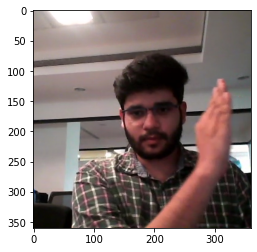

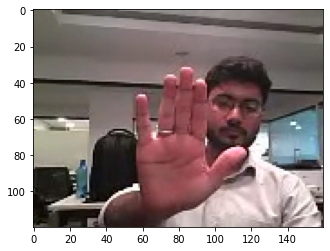

In [33]:
#360 by 360
image1 = imread("/home/datasets/Project_data/train/WIN_20180907_15_38_24_Pro_Right Swipe_new/WIN_20180907_15_38_24_Pro_00029.png")
#160 by 120
image2 = imread("/home/datasets/Project_data/train/WIN_20180926_17_52_26_Pro_Stop_new/WIN_20180926_17_52_26_Pro_00044.png")

print("image shapes before cropping and resizing", image1.shape, image2.shape)

plt.imshow(image1)
plt.show()

plt.imshow(image2)
plt.show()

#### After Standardisation

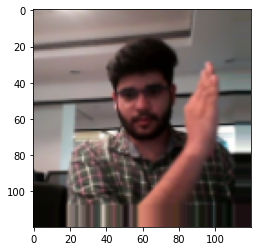

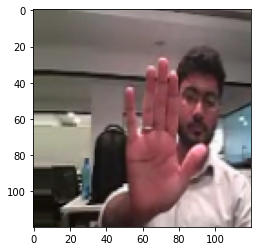

image shapes after cropping and resizing (120, 120, 3) (120, 120, 3)


In [34]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    featurewise_center=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()

image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()

print("image shapes after cropping and resizing", image1.shape, image2.shape)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes                    
                    image = resize(image, (height, width), anti_aliasing=True)

                    #randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    # crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_classes = 5

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3d Models

In [13]:
# function for conv3d models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # now that you have written the model, the next step is to `compile` the model.
    # when you print the `summary` of the model, you'll see the total number of parameters you have to train.
    opt = tf.keras.optimizers.Adam() # write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### Model 1
#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [13]:
#write your model here
num_epochs = 25 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 30
print('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print(model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

2024-08-26 12:59:36.880400: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-26 12:59:36.880465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [15]:
callbacks_list = model_callbacks("model_conv3D_1")

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [16]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25


2024-08-26 12:59:41.606300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6096 - categorical_accuracy: 0.4314Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 6.26357, saving model to model_conv3D_1_2024-08-2612_59_36.048275/model-00001-1.60955-0.43137-6.26357-0.16000.h5
67/67 [==============================] - 174s 3s/step - loss: 1.6096 - categorical_accuracy: 0.4314 - val_loss: 6.2636 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1247 - categorical_accuracy: 0.5792
Epoch 00002: val_loss did not improve from 6.26357
67/67 [==============================] - 152s 2s/step - loss: 1.1247 - categorical_accuracy: 0.5792 - val_loss: 6.8324 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9728 - categorical_accuracy: 0.6259
Epoch 00003: val_loss did not improve from 6.26357
67/67 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


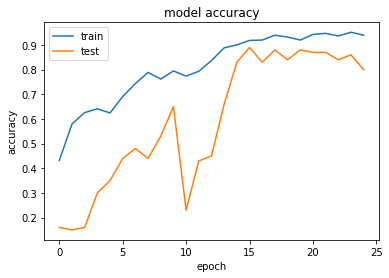

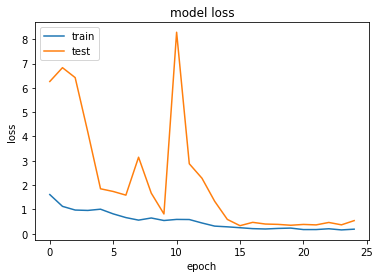

In [18]:
plot_loss_accuracy(history)

### Model 2
#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [19]:
num_epochs = 20 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 20
print('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print(model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                            

In [20]:
train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [21]:
callbacks_list = model_callbacks("model_conv3D_2")

In [22]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [23]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4246 - categorical_accuracy: 0.4676Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.62041, saving model to model_conv3D_2_2024-08-2612_59_36.048275/model-00001-1.42458-0.46757-2.62041-0.22000.h5
67/67 [==============================] - 135s 2s/step - loss: 1.4246 - categorical_accuracy: 0.4676 - val_loss: 2.6204 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2277 - categorical_accuracy: 0.5158
Epoch 00002: val_loss did not improve from 2.62041
67/67 [==============================] - 126s 2s/step - loss: 1.2277 - categorical_accuracy: 0.5158 - val_loss: 3.8924 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0268 - categorical_accuracy: 0.6199
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


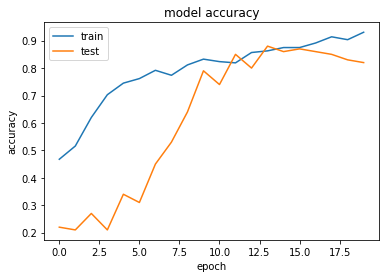

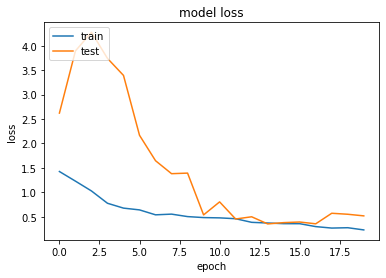

In [24]:
plot_loss_accuracy(history)

### Model 3
#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [25]:
num_epochs = 15 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 30
print('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print(model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

In [26]:
train_generator = generator(train_path, train_doc, batch_size, augment=True, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
callbacks_list = model_callbacks("model_conv3D_3")

In [28]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [29]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.6417 - categorical_accuracy: 0.4193Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.03881, saving model to model_conv3D_3_2024-08-2612_59_36.048275/model-00001-1.64174-0.41931-2.03881-0.28000.h5
67/67 [==============================] - 192s 3s/step - loss: 1.6417 - categorical_accuracy: 0.4193 - val_loss: 2.0388 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2835 - categorical_accuracy: 0.5068
Epoch 00002: val_loss did not improve from 2.03881
67/67 [==============================] - 179s 3s/step - loss: 1.2835 - categorical_accuracy: 0.5068 - val_loss: 3.2094 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1365 - categorical_accuracy: 0.5656
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


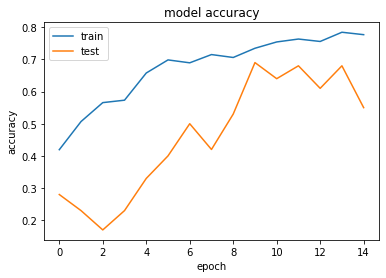

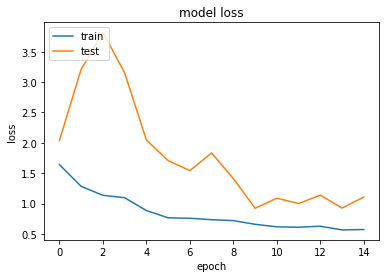

In [30]:
plot_loss_accuracy(history)

### Model 4
#### Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [31]:
num_epochs = 25 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 30
print('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print(model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                            

In [32]:
train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [33]:
callbacks_list = model_callbacks("model_conv3D_4")

In [34]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [35]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5654 - categorical_accuracy: 0.4480Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 2.72028, saving model to model_conv3D_4_2024-08-2612_59_36.048275/model-00001-1.56544-0.44796-2.72028-0.16000.h5
67/67 [==============================] - 158s 2s/step - loss: 1.5654 - categorical_accuracy: 0.4480 - val_loss: 2.7203 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1973 - categorical_accuracy: 0.5415
Epoch 00002: val_loss did not improve from 2.72028
67/67 [==============================] - 156s 2s/step - loss: 1.1973 - categorical_accuracy: 0.5415 - val_loss: 3.7845 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9555 - categorical_accuracy: 0.6214
Epoch 000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


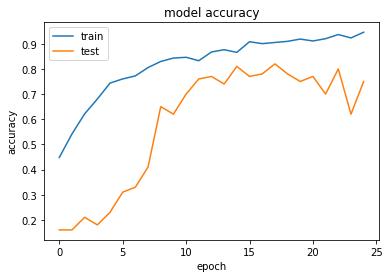

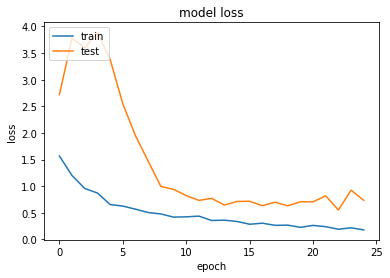

In [36]:
plot_loss_accuracy(history)

### Model 5
#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120) and Batch size 20

In [14]:
#write your model here
num_epochs = 25 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 20
print('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print(model.summary())

# epochs = 25
# batch size = 20
# num_frames per video = 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                              

2024-08-27 03:13:29.783184: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-27 03:13:29.783248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
callbacks_list = model_callbacks("model_conv3D_5")

In [17]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [18]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25


2024-08-27 03:13:41.660578: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4870 - categorical_accuracy: 0.4374Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.85769, saving model to model_conv3D_5_2024-08-2703_12_39.865129/model-00001-1.48700-0.43741-1.85769-0.26000.h5
34/34 [==============================] - 120s 4s/step - loss: 1.4870 - categorical_accuracy: 0.4374 - val_loss: 1.8577 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1295 - categorical_accuracy: 0.5882
Epoch 00002: val_loss did not improve from 1.85769
34/34 [==============================] - 106s 3s/step - loss: 1.1295 - categorical_accuracy: 0.5882 - val_loss: 3.4156 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.8009 - categorical_accuracy: 0.6953
Epoch 00003: val_loss did not improve from 1.85769
34/34 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


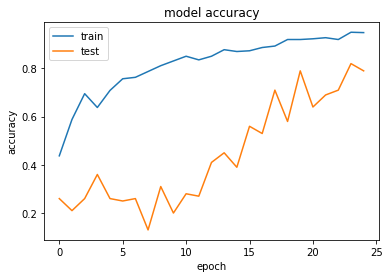

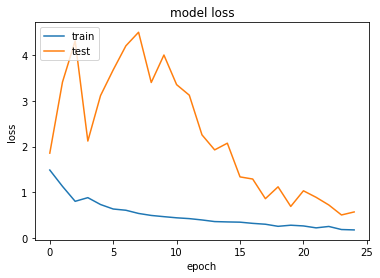

In [ ]:
plot_loss_accuracy(history)

## TRANSFER LEARNING - MobileNet Conv2d + GRU

In [ ]:
def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

### Model 6
#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 20
print('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
    

In [ ]:
train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

In [ ]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [ ]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 0.1819 - categorical_accuracy: 0.9442
Epoch 00008: val_loss did not improve from 0.25263
67/67 [==============================] - 103s 2s/step - loss: 0.1819 - categorical_accuracy: 0.9442 - val_loss: 0.4170 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 9/20
67/67 [==============================] - ETA: 0s - loss: 0.1624 - categorical_accuracy: 0.9487
Epoch 00009: val_loss did not improve from 0.25263
67/67 [==============================] - 104s 2s/step - loss: 0.1624 - categorical_accuracy: 0.9487 - val_loss: 0.5460 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 10/20
67/67 [==============================] - ETA: 0s - loss: 0.1527 - categorical_accuracy: 0.9578
Epoch 00010: val_loss did not improve from 0.25263

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 103s

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


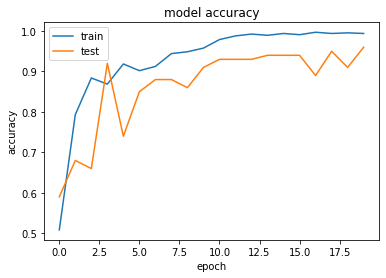

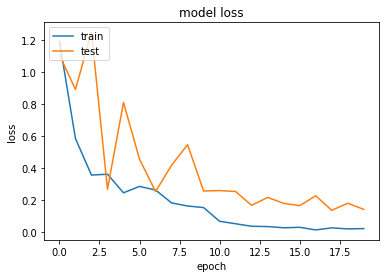

In [ ]:
plot_loss_accuracy(history)

### Model 7
#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [ ]:
num_epochs = 15 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 30
print('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
    

In [36]:
train_generator = generator(train_path, train_doc, batch_size, augment=True, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [37]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_random")

In [38]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [39]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.2084 - categorical_accuracy: 0.5219Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 0.79597, saving model to model_retrain_mobilenet_gru_random_2024-08-2703_12_39.865129/model-00001-1.20842-0.52187-0.79597-0.63000.h5
67/67 [==============================] - 177s 3s/step - loss: 1.2084 - categorical_accuracy: 0.5219 - val_loss: 0.7960 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.5550 - categorical_accuracy: 0.7843
Epoch 00002: val_loss improved from 0.79597 to 0.38247, saving model to model_retrain_mobilenet_gru_random_2024-08-2703_12_39.865129/model-00002-0.55504-0.78431-0.38247-0.83000.h5
67/67 [==============================] - 174s 3s/step - loss: 0.5550 - categorical_accuracy: 0.7843 - val_loss: 0.3825 - val_categori

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


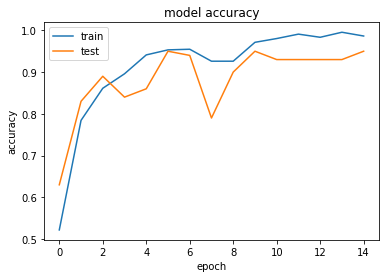

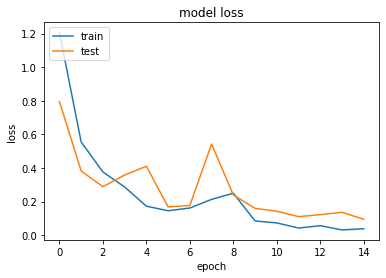

In [40]:
plot_loss_accuracy(history)

### Model 8
#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes - Trying with Batch size 30

In [42]:
num_epochs = 20 # choose the number of epochs
print('# epochs =', num_epochs)
batch_size = 30  #experiment with the batch size
print('# batch size =', batch_size)
num_frames = 20
print('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print(model.summary())

# epochs = 20
# batch size = 30
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [43]:
train_generator = generator(train_path, train_doc, batch_size, num_images=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_images=num_frames)

In [44]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_batch_30")

In [45]:
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

In [46]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.1983 - categorical_accuracy: 0.5249Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.22032, saving model to model_retrain_mobilenet_gru_batch_30_2024-08-2703_12_39.865129/model-00001-1.19834-0.52489-1.22032-0.56000.h5
23/23 [==============================] - 120s 5s/step - loss: 1.1983 - categorical_accuracy: 0.5249 - val_loss: 1.2203 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.4082 - categorical_accuracy: 0.8582
Epoch 00002: val_loss improved from 1.22032 to 0.77118, saving model to model_retrain_mobilenet_gru_batch_30_2024-08-2703_12_39.865129/model-00002-0.40821-0.85822-0.77118-0.75000.h5
23/23 [==============================] - 103s 5s/step - loss: 0.4082 - categorical_accuracy: 0.8582 - val_loss: 0.7712 - val_cate

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


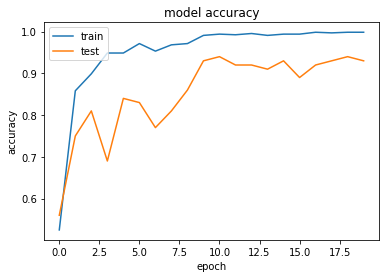

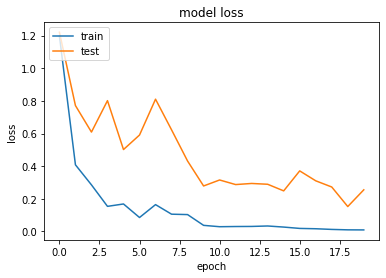

In [47]:
plot_loss_accuracy(history)